  2%|▏         | 9/500 [00:09<08:46,  1.07s/it]

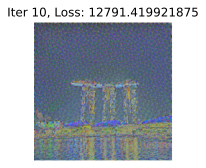

  4%|▍         | 19/500 [00:20<08:36,  1.07s/it]

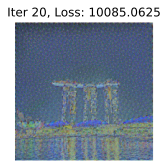

  6%|▌         | 29/500 [00:30<08:28,  1.08s/it]

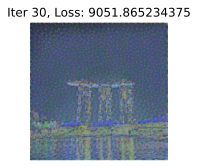

  8%|▊         | 39/500 [00:41<08:14,  1.07s/it]

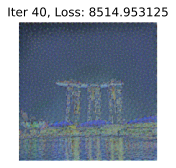

 10%|▉         | 49/500 [00:52<07:52,  1.05s/it]

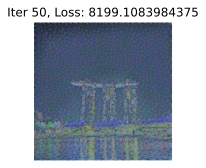

 12%|█▏        | 59/500 [01:02<07:46,  1.06s/it]

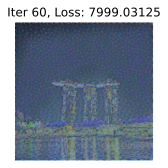

 14%|█▍        | 69/500 [01:13<07:37,  1.06s/it]

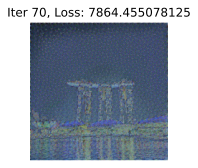

 16%|█▌        | 79/500 [01:24<07:28,  1.06s/it]

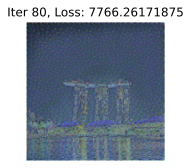

 18%|█▊        | 89/500 [01:35<07:25,  1.08s/it]

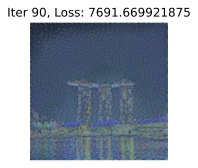

 20%|█▉        | 99/500 [01:46<07:13,  1.08s/it]

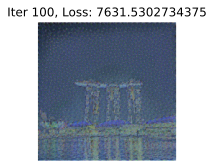

 22%|██▏       | 109/500 [01:56<06:44,  1.04s/it]

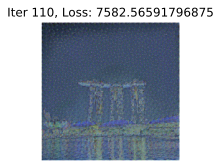

 24%|██▍       | 119/500 [02:07<06:36,  1.04s/it]

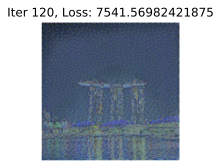

 26%|██▌       | 129/500 [02:17<06:33,  1.06s/it]

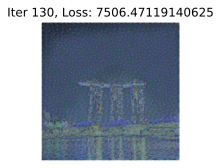

 28%|██▊       | 139/500 [02:28<06:22,  1.06s/it]

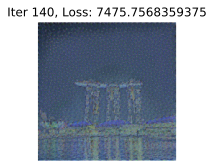

 30%|██▉       | 149/500 [02:39<06:05,  1.04s/it]

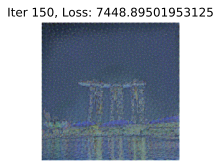

 32%|███▏      | 159/500 [02:49<06:03,  1.06s/it]

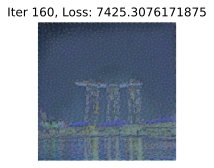

 34%|███▍      | 169/500 [03:00<05:43,  1.04s/it]

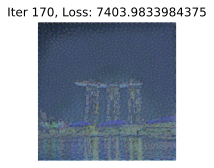

 36%|███▌      | 179/500 [03:10<05:31,  1.03s/it]

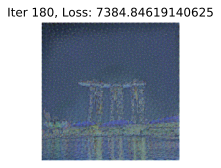

 38%|███▊      | 189/500 [03:21<05:20,  1.03s/it]

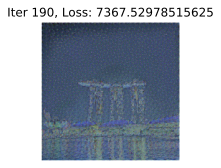

 40%|███▉      | 199/500 [03:31<05:23,  1.07s/it]

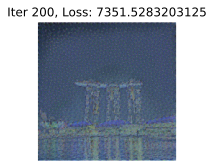

 42%|████▏     | 209/500 [03:43<05:21,  1.10s/it]

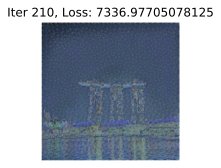

 44%|████▍     | 219/500 [03:54<05:05,  1.09s/it]

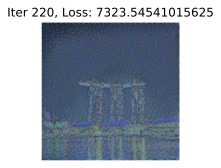

 46%|████▌     | 229/500 [04:04<04:47,  1.06s/it]

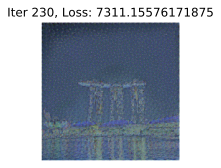

 48%|████▊     | 239/500 [04:15<04:43,  1.09s/it]

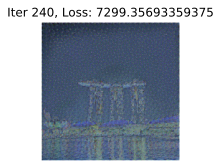

 50%|████▉     | 249/500 [04:26<04:27,  1.07s/it]

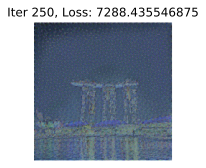

 52%|█████▏    | 259/500 [04:37<04:31,  1.13s/it]

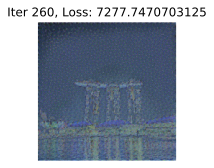

 54%|█████▍    | 269/500 [04:48<04:16,  1.11s/it]

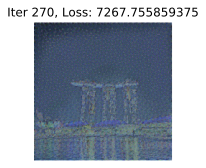

 56%|█████▌    | 279/500 [04:58<03:41,  1.00s/it]

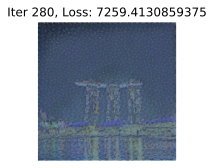

 58%|█████▊    | 289/500 [05:09<03:48,  1.08s/it]

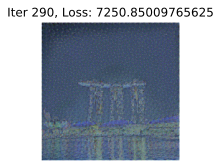

 60%|█████▉    | 299/500 [05:20<03:35,  1.07s/it]

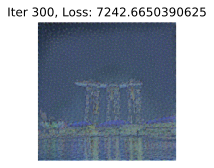

 62%|██████▏   | 309/500 [05:30<03:04,  1.04it/s]

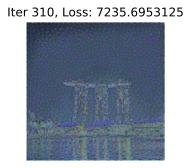

 64%|██████▍   | 319/500 [05:40<03:10,  1.05s/it]

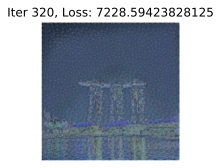

 66%|██████▌   | 329/500 [05:50<02:53,  1.02s/it]

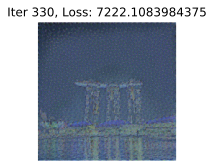

 68%|██████▊   | 339/500 [06:01<02:55,  1.09s/it]

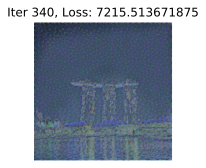

 70%|██████▉   | 349/500 [06:12<02:47,  1.11s/it]

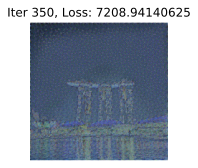

 72%|███████▏  | 359/500 [06:23<02:35,  1.10s/it]

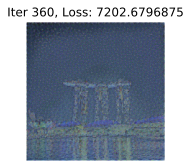

 74%|███████▍  | 369/500 [06:35<02:25,  1.11s/it]

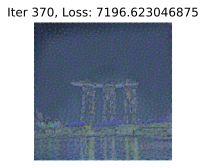

 76%|███████▌  | 379/500 [06:46<02:12,  1.10s/it]

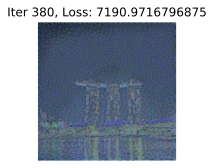

 77%|███████▋  | 386/500 [06:54<02:02,  1.07s/it]


KeyboardInterrupt: 

In [22]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import models
from torchvision import transforms
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import argparse


class VGGNet(nn.Module):
    def __init__(self):
        super().__init__()
        # content on conv4_2
        # style on conv1_1, conv2_1, conv3_1, conv4_1, conv5_1
        self.select = ['0', '5', '10', '19', '28', '20']
        vgg = models.vgg19(weights=True).features  # pretrained VGG19 model
        for param in vgg.parameters():
            param.requires_grad_(False)
        net = []
        for layer in vgg:
            net += self.replace_layers(layer)
        self.vgg = nn.Sequential(*net)
    
    def replace_layers(self, layer):
        if isinstance(layer, nn.MaxPool2d):
            return [nn.AvgPool2d(kernel_size=layer.kernel_size, stride=layer.stride, padding=layer.padding)]
        elif isinstance(layer, nn.Conv2d):
            norm = nn.InstanceNorm2d(layer.out_channels, affine=True)
            norm.requires_grad_(False)
            return [layer, norm]
        return [layer]

    def forward(self, x):
        features = []
        for name, layer in self.vgg._modules.items():
            x = layer(x)
            if name in self.select:
                features.append(x)
        return features


def preprocess(
        image_path,
        max_size=None,
        shape=None,
        transform=None,
        device=None
):
    """
    read an image
    process it to tensor available for vgg
    """
    image = Image.open(image_path)
    if max_size:
        scale = max_size / max(image.size)
        size = np.array(image.size) * scale
        image = image.resize(size.astype(int), Image.ANTIALIAS)
    if shape:
        image = image.resize(shape, Image.LANCZOS)
    if transform:
        image = transform(image).unsqueeze(0)
    return image.to(device)


def postprocess(tensor):
    """
    convert a tensor to an image
    """
    image = tensor.to("cpu").clone().detach()
    image = image.numpy().squeeze()
    image = image.transpose(1, 2, 0)
    image = image * np.array((0.229, 0.224, 0.225)) + np.array((0.485, 0.456, 0.406))
    image = image.clip(0, 1)
    return image


def get_features(image, model):
    """
    get feature vectors
    """
    layers = model(image)
    features = []
    for layer in layers:
        feature = layer.reshape(layer.shape[1], -1)
        features.append(feature)
    return features


def gram_matrix(tensor):
    gram = torch.mm(tensor, tensor.t())
    return gram


if __name__ == "__main__":
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    image_size = 356
    img_path = './img/'
    save_path = './results/'
    content_path = f'{img_path}content1.jpg'
    style_path = f'{img_path}style.jpg'

    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(
            (0.485, 0.456, 0.406),
            (0.229, 0.224, 0.225)
        )
    ])

    # load content and style image
    content = preprocess(
        content_path,
        shape=[image_size, image_size],
        transform=transform,
        device=device
    )
    style = preprocess(
        style_path,
        shape=[image_size, image_size],
        transform=transform,
        device=device
    )

    model = VGGNet().to(device).eval()

    # get content and style features
    content_features = get_features(content, model)
    style_features = get_features(style, model)
    style_grams = [gram_matrix(feature[:-1]) for feature in style_features]

    # white noise image
    target = torch.randn_like(content).requires_grad_(True).to(device)

    w = 1/5  # w_l
    alpha = 1  # alpha
    beta = 1e6  # beta
    content_weight = 1 / 2
    style_weights = [1 / (f.shape[0]**2 * f.shape[1]**2) / 4 for f in style_features]
    optimizer = optim.LBFGS([target], lr=0.5)
    steps = 500
    show_every = 10

    def closure():
        optimizer.zero_grad()
        target_features = get_features(target, model)
        content_loss = F.mse_loss(target_features[-1], content_features[-1], reduction='sum') * content_weight
        style_loss = 0
        for target_feature, style_gram, weight in zip(
                target_features,
                style_grams,
                style_weights
        ):
            target_gram = gram_matrix(target_feature[:-1])
            style_loss += F.mse_loss(target_gram, style_gram, reduction='sum') * weight * w
        total_loss = alpha * content_loss + beta * style_loss
        total_loss.backward()
        return total_loss

    for i in tqdm(range(1, steps + 1)):
        optimizer.step(closure)
        loss = closure()
        if i % show_every == 0:
            plt.imshow(postprocess(target))
            plt.axis("off")
            plt.title(f"Iter {i}, Loss: {loss.item()}")
            plt.show()

    # save image
    plt.imshow(postprocess(target))
    plt.axis("off")
    content_name = content_path.split('/')[-1].split('.')[0]
    style_name = style_path.split('/')[-1].split('.')[0]
    plt.savefig(f'{save_path}{content_name}_{style_name}.png')
    plt.show()